<h1> Cleavage Site and TAP Prediction </h1>


This tutorial illustrates the use of Fred2 to predict the steps of the HLA-I antigen processing pathway including proteasomal cleavage and TAP transport. Fred2 offers a long list of prediction methods and was  designed in such a way that extending Fred2 with your favorite method is easy.

This tutorial will entail:
- Simple cleavage site/fragment prediction from a list of peptide sequences and protein sequences
- Simple TAP prediction methods
- Consensus prediction of proteasomal cleavage, TAP, and HLA binding to model the complete antigen processing pathway


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from Fred2.Core import Protein, Peptide, Allele
from Fred2.Core import generate_peptides_from_protein
from Fred2.IO import read_fasta
from Fred2.CleavagePrediction import CleavageSitePredictorFactory, CleavageFragmentPredictorFactory
from Fred2.TAPPrediction import TAPPredictorFactory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2> Chapter 1: Cleavage Prediction </h2>
<br/>
Fred2 offers a comprehensive list of state-of-the art proteasomal cleavage prediction methods. Usually one distinguishes cleavage methods into cleavage site and cleavage fragment prediction. Cleavage site prediction methods predict each possible cleavage site within a given amino acid sequence, whereas cleavage fragment prediction methods predict the likelihood of a peptide fragment of being a product of proteasomal cleavage. Additionally, the source of the training data are often also quite different. The majority of prediction tools was train on in vitro data of up to three fully analyzed proteins and distinguish between constitutive and immunoproteasomal cleavage. Some prediction methods use natural HLA ligands as training data as they are products of antigen processing pathway and therefore also of cleavage events.
<br/><br/>
But all methods start with reading in protein sequences. Fred2 offers several ways of defining Proteins. We can either directly initialize a `Fred2.Core.Protein` object by specifying a amino acid sequence and optionally a progenitor gene and transcript id, as well as the progenitor `Fred2.Core.Transcript` object, or we can directly read in proteins from FASTA files by using `Fred2.IO.read_fasta`.  

In [3]:
protein = Protein("AAAAAAAAAAA",_gene_id="Dummy", _transcript_id="Dummy")
proteins = read_fasta("./data/proteins.fasta", id_position=3, type=Protein)
protein

PROTEIN: AAAAAAAAAAA (aa-seq)
		  Dummy (orig transcript)
		 VARIANTS:

Once we have a protein sequence to work with, we can specify the cleavage site prediction method of our choice. Fred2 offers one entry point for each type of prediction methods via so called factories. For cleavage site prediction it is `CleavageSitePredictorFactory`. To get an overview which prediction methods are currently implemented, we can use `CleavageSitePredictorFactory` as follows:

In [5]:
for name,version in CleavageSitePredictorFactory.available_methods().iteritems():
    print name, ",".join(version)

proteasmm_i 1.0
netchop 3.1
proteasmm_c 1.0
pcm 1.0


Lets select `PCM` for example and make predictions:

In [6]:
pcm = CleavageSitePredictorFactory("PCM")
site_result = pcm.predict(proteins)
site_result.head()

Seq      pcm
ID          Pos             
NP_852610.1 0     M  0.00000
            1     K  0.00000
            2     M  0.00000
            3     R -1.77936
            4     F -0.87673

To specify a particular version of a prediction method, we can use the flag `version=""` when calling the PredictorFactories. If we do not specify any version, Fred2 will initialize the most recent version that is supported.

In [15]:
pcm = CleavageSitePredictorFactory("PCM", version="1.0")
site_result = pcm.predict(proteins)
site_result.head()

Seq      pcm
ID          Pos             
NP_852610.1 0     M  0.00000
            1     K  0.00000
            2     M  0.00000
            3     R -1.77936
            4     F -0.87673

External tools like `NetChop` offer two additional flags when calling `.predict()`, `command="/path/to/binary"` and `options="command options"`. `command=""` specifies the path to an alternative binary that should be used instead of the one which is globally registered. With options you can specify additional commands that will directly be passed to the command line call without any sanity checks.

In [ ]:
pcm = CleavageSitePredictorFactory("NetChop")
site_result = pcm.predict(proteins, options="")
site_result.head()
#TODO this has to be executed on a Linux machine!

For CleavageFragment prediction we first have to generate peptides from protein sequences with `Fred2.Core.generate_peptides_from_proteins`. Fred2 currently supports only one CleavageFragment prediction methods proposed by Ginodi et al. <a href="http://bioinformatics.oxfordjournals.org/content/24/4/477.long">(Ginodi, et al.(2008) Bioinformatics 24(4))</a>, which supports only 11mers (9mer epitopes and two flaking amino acids).

In [8]:
pep = generate_peptides_from_protein(proteins, 11)
CleavageFragmentPredictorFactory("Ginodi").predict(pep).head()

,ginodi
"(((A)), ((A)), ((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)))",-18.891867
"(((A)), ((D)), ((R)), ((C)), ((K)), ((E)), ((V)), ((Q)), ((Q)))",-14.992024
"(((A)), ((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)))",-14.755080
"(((C)), ((G)), ((K)), ((A)), ((A)), ((V)), ((D)), ((P)), ((A)))",-17.551360
"(((C)), ((K)), ((E)), ((V)), ((Q)), ((Q)), ((I)), ((R)), ((D)))",-17.682320


The result object is based on pandas' `DataFrame`, thus all possibilities of manipulating the results pandas offers are possible, including rudimentary plotting capabilities.

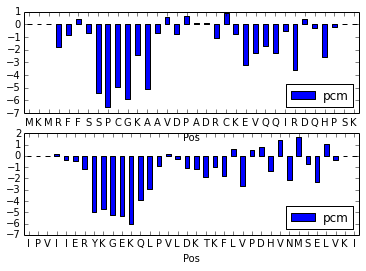

In [82]:
import matplotlib.pyplot as plt

f, a = plt.subplots(len(site_result.index.levels[0]),1)

for i,r in enumerate(site_result.index.levels[0]):
    site_result.xs(r).plot(kind='bar', ax=a[i]).set_xticklabels(site_result.loc[(r,slice(None)),"Seq"], rotation=0)


We also can combine several prediction results of the same type via `CleavageSitePredictionResults.merge_results` (Note this function returns a merge Result DataFrame):

In [11]:
import pandas as pd
import numpy

site_result2 = CleavageSitePredictorFactory("proteasmm_c").predict(proteins)
merged_result = site_result.merge_results([site_result2])
merged_result.head(7)

Seq       pcm  proteasmm_c
ID          Pos                           
NP_852610.1 0     M  0.000000     0.000000
            1     K  0.000000     0.000000
            2     M  0.000000     0.000000
            3     R -1.779360     0.000000
            4     F -0.876730     0.000000
            5     F  0.379716     0.967189
            6     S -0.682109     0.848493

We can also filter the results based on multiple expressions with `CleavageSitePredictionResults.filter_result`.

In [84]:
comp = lambda x,y: x > y
expressions=[("pcm",comp,0)]

merged_result.filter_result(expressions)

Seq       pcm  proteosmm_c
ID              Pos                           
NP_852610.1     5     F  0.379716     0.967189
                14    V  0.563343     0.806216
                16    P  0.662944     1.011543
                17    A  0.115836     0.740608
                18    D  0.124760     1.060129
                20    C  0.853636     0.963365
                28    D  0.445906     1.130923
NP_852610_part2 3     I  0.159584     0.000000
                15    V  0.168248     1.003839
                22    L  0.589015     1.141511
                24    P  0.523189     0.928291
                25    D  0.804995     1.003516
                27    V  1.404717     0.989936
                29    M  1.662398     1.064119
                32    L  1.071719     0.000000

<h2> Chapter 2: TAP prediction </h2>

Fred2 offers only limited prediction methods for TAP prediction, due to lack of publicly available methods.

In [14]:
for name,version in TAPPredictorFactory.available_methods().iteritems():
    print name, ",".join(version)

svmtap 1.0
smmtap 1.0
doytchinova 1.0


For TAP prediction, we first have to generate peptides. Lets take the proteins we already imported and generate 9mers, as these two methods only support 9mer peptides.

In [87]:
pep = generate_peptides_from_protein(proteins,9)
tap_result = TAPPredictorFactory("SVMTAP").predict(pep)
tap_result.head()

,svmtap
"(((A)), ((A)), ((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)))",-47.782823
"(((A)), ((D)), ((R)), ((C)), ((K)), ((E)), ((V)), ((Q)), ((Q)))",-38.337527
"(((A)), ((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)))",-40.900773
"(((C)), ((G)), ((K)), ((A)), ((A)), ((V)), ((D)), ((P)), ((A)))",-31.988850
"(((C)), ((K)), ((E)), ((V)), ((Q)), ((Q)), ((I)), ((R)), ((D)))",-38.903919


Again we can do all rudimentary operations on the result object as with the cleavage result objects, including merging and filtering.

In [106]:
tap_result2 = TAPPredictorFactory("TAPDoytchinova").predict(pep[:15])
tap_result.merge_results(tap_result2).head()

,svmtap,doytchinova
"(((A)), ((A)), ((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)))",-47.782823,NaN
"(((A)), ((D)), ((R)), ((C)), ((K)), ((E)), ((V)), ((Q)), ((Q)))",-38.337527,-0.466
"(((A)), ((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)))",-40.900773,NaN
"(((C)), ((G)), ((K)), ((A)), ((A)), ((V)), ((D)), ((P)), ((A)))",-31.988850,-2.070
"(((C)), ((K)), ((E)), ((V)), ((Q)), ((Q)), ((I)), ((R)), ((D)))",-38.903919,NaN


In [111]:
from operator import ge

tap_result.filter_result([("svmtap",ge, -30)])

,svmtap
"(((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)), ((E)), ((V)))",-25.560005
"(((F)), ((S)), ((S)), ((P)), ((C)), ((G)), ((K)), ((A)), ((A)))",-19.259415
"(((M)), ((R)), ((F)), ((F)), ((S)), ((S)), ((P)), ((C)), ((G)))",-26.315791
"(((S)), ((P)), ((C)), ((G)), ((K)), ((A)), ((A)), ((V)), ((D)))",-24.671547
"(((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)), ((E)))",-14.140251
"(((V)), ((P)), ((D)), ((H)), ((V)), ((N)), ((M)), ((S)), ((E)))",-23.865406


<h2> Chapter 3: Consensus prediction for natural ligand prediction </h2>
<br/>
Proteasomal cleavage, TAP prediction, as well as HLA binding prediction have been combined to increase the specificity of predicting natural processed HLA ligands. One example is `WAPP` <a href="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2279325/">(Dönnes, et al.(2005). Protein Science 14(8))</a>, which uses proteasomal cleavage and TAP prediction methods to filter for possibly processed peptides.

The same approach can be implemented with Fred2. We start again with the two protein sequences and exemplify the workflows for CleavageFragmentPrediction and CleavageSitePrediction methods.


<h4> Antigen processing prediction with CleavageFragment prediction </h4>
<br/>
We will use `PSSMGinodi`, `SVMTAP`, and `UniTope` for prediction for HLA-A*02:01. For `PSSMGionid` and `SVMTAP` we use a threshold of -15.0 and -30 respectively.


In [16]:
from operator import ge
from Fred2.Core import Allele
from Fred2.EpitopePrediction import EpitopePredictorFactory

allele = Allele("HLA-A*02:01")

pep = generate_peptides_from_protein(proteins,11)
print "Number of peptides: ", len(pep)

#cleavage prediction and filtering
df_cl = CleavageFragmentPredictorFactory("Ginodi").predict(pep).filter_result(("ginodi",ge,-15))
print "Number of peptides after proteasomal cleavage: ", len(df_cl)

#tap prediction and filtering
df_tap = TAPPredictorFactory("SVMTAP").predict(df_cl.index).filter_result(("svmtap",ge,-30))
print "Number of peptides after TAP transport: ", len(df_tap)

#epitope prediction and filtering
df_epi = EpitopePredictorFactory("UniTope").predict(df_tap.index,alleles=allele)
df_epi

Number of peptides:  50
Number of peptides after proteasomal cleavage:  31
Number of peptides after TAP transport:  6


,,A*02:01
Seq,Method,
"(((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)), ((E)), ((V)))",unitope,-1.771554
"(((F)), ((S)), ((S)), ((P)), ((C)), ((G)), ((K)), ((A)), ((A)))",unitope,-1.221980
"(((M)), ((R)), ((F)), ((F)), ((S)), ((S)), ((P)), ((C)), ((G)))",unitope,-2.002212
"(((S)), ((P)), ((C)), ((G)), ((K)), ((A)), ((A)), ((V)), ((D)))",unitope,-5.042082
"(((V)), ((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)), ((E)))",unitope,-4.721389
"(((V)), ((P)), ((D)), ((H)), ((V)), ((N)), ((M)), ((S)), ((E)))",unitope,-4.195872


Based on this analysis, there are no natural ligands predicted for the two test proteins.

<h4> Antigen processing prediction with CleavageSite prediction </h4>
<br/>
We will use `PCM`, `SVMTAP`, and `SVMHC` for prediction for HLA-A*02:01 like in the original work of WAPP. For `PCM` and `SVMTAP` we use a threshold of −4.8 and −27 respectively.


In [18]:
from operator import ge
from Fred2.Core import Allele,Protein
from Fred2.EpitopePrediction import EpitopePredictorFactory

allele = Allele("HLA-A*02:01")



#cleavage prediction and filtering
df_cl = CleavageSitePredictorFactory("PCM").predict(proteins).filter_result(("pcm",ge,-4.8))

print "Number of peptides after proteasomal cleavage: ", len(df_cl)

#since we only predicted possible cleavage site, we now have to generate all possible peptides
#peptides
pep_dic = {}
for p in proteins:
    for i in df_cl.loc[(p.transcript_id,slice(None)),:].index.labels[1]:
        if i-8>=0:
            seq = str(p[i-8:i+1])
            pep_dic.setdefault(seq, []).append(p)
peps = [Peptide(seq,proteins={pp.transcript_id:pp for pp in p}) for seq, p in pep_dic.iteritems()]


#tap prediction and filtering
df_tap = TAPPredictorFactory("SVMTAP").predict(peps).filter_result(("svmtap",ge,-27))
print "Number of peptides after TAP transport: ", len(df_tap)

#epitope prediction and filtering
df_epi = EpitopePredictorFactory("SVMHC").predict(df_tap.index,alleles=allele).filter_result(("svmhc",ge,-1.0))
df_epi

Number of peptides after proteasomal cleavage:  61
Number of peptides after TAP transport:  5


,,A*02:01
Seq,Method,
"(((D)), ((P)), ((A)), ((D)), ((R)), ((C)), ((K)), ((E)), ((V)))",svmhc,-0.552764
"(((V)), ((P)), ((D)), ((H)), ((V)), ((N)), ((M)), ((S)), ((E)))",svmhc,-0.992899


Here as well, we do not predict any natural ligands.